In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time
import geopandas as gpd
import math
from utils import *
from deep_shadow import *

import datashader as ds
from shapely import wkt
from pyproj import Transformer
from shapely.geometry import box
import spatialpandas as sp
import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
winter_gt = pd.read_csv('./data/shadows/nyc-winter.csv')
winter_pred = pd.read_csv('./data/shadows_new/nyc-winter.csv')

In [32]:
# convert to gdf and plot
gdf_gt = gpd.GeoDataFrame(winter_gt, crs='EPSG:4326', geometry=winter_gt['geometry'].apply(wkt.loads))
gdf_gt = gdf_gt.to_crs('EPSG:3395')
gdf_gt['geometry'] = gdf_gt['geometry'].apply(lambda x: x.buffer(5))

In [33]:
gdf_pred = gpd.GeoDataFrame(winter_pred, crs='EPSG:4326', geometry=winter_pred['geometry'].apply(wkt.loads))
gdf_pred = gdf_pred.to_crs('EPSG:3395')
gdf_pred['geometry'] = gdf_pred['geometry'].apply(lambda x: x.buffer(5))

In [4]:
transformer = Transformer.from_crs(3395, 4326)
invtransformer = Transformer.from_crs(4326,3395)

In [5]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [6]:
import datashader as ds
from datashader.core import bypixel

def polygons(self, source, geometry, agg=None):
    from datashader.glyphs import PolygonGeom
    from datashader.reductions import any as any_rdn
    from spatialpandas import GeoDataFrame
    from spatialpandas.dask import DaskGeoDataFrame
    if isinstance(source, DaskGeoDataFrame):
        # Downselect partitions to those that may contain polygons in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx_partitions[slice(*x_range), slice(*y_range)]
    elif isinstance(source, gpd.GeoDataFrame):
        # Downselect actual rows to those for which the polygon is in viewport
        x_range = self.x_range if self.x_range is not None else (None, None)
        y_range = self.y_range if self.y_range is not None else (None, None)
        source = source.cx[slice(*x_range), slice(*y_range)]
        # Convert the subset to ragged array format of spatialpandas
        geometries = spatialpandas_from_pygeos(source.geometry.array.data)
        source = pd.DataFrame(source)
        source["geometry"] = geometries
    elif not isinstance(source, GeoDataFrame):
        raise ValueError(
            "source must be an instance of spatialpandas.GeoDataFrame or \n"
            "spatialpandas.dask.DaskGeoDataFrame.\n"
            "  Received value of type {typ}".format(typ=type(source)))

    if agg is None:
        agg = any_rdn()
    glyph = PolygonGeom(geometry)
    return bypixel(source, self, glyph, agg)

ds.Canvas.polygons = polygons
cvs = ds.Canvas(plot_width=256, plot_height=256)

In [37]:
i, j = 19262, 24684
bb0 = num2deg(i,j,16)
bb1 = num2deg(i+1,j+1,16)

bb0 = invtransformer.transform(bb0[0],bb0[1])
bb1 = invtransformer.transform(bb1[0],bb1[1])

bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])


<Axes: >

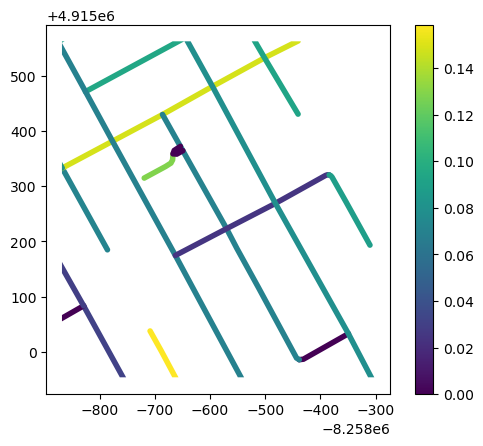

In [40]:
roads = gdf_gt.loc[gdf_gt.sindex.intersection(bbox.bounds)]

proxy = pd.DataFrame({'geometry': bbox}, index=[roads.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(roads, proxy)
clipped.plot(column='mean', legend=True)

<Axes: >

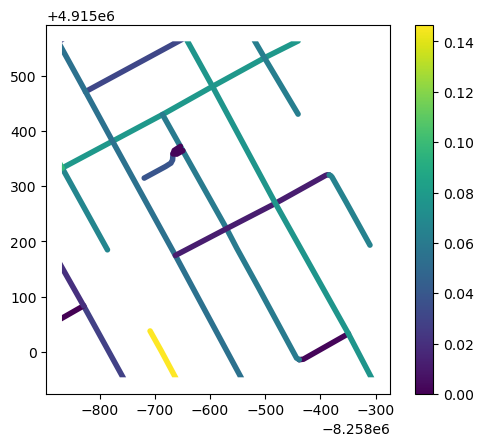

In [43]:
roads = gdf_pred.loc[gdf_pred.sindex.intersection(bbox.bounds)]

proxy = pd.DataFrame({'geometry': bbox}, index=[roads.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(roads, proxy)
clipped.plot(column='mean', legend=True)

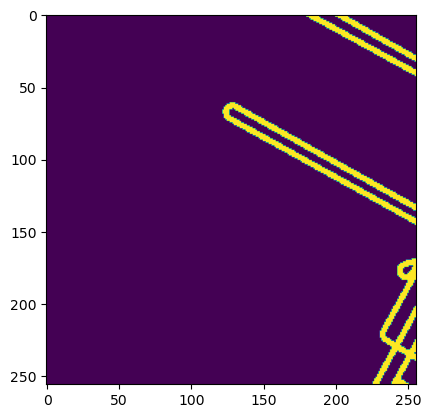

In [23]:
i, j = 19296, 24627
bb0 = num2deg(i,j,16)
bb1 = num2deg(i+1,j+1,16)

bb0 = invtransformer.transform(bb0[0],bb0[1])
bb1 = invtransformer.transform(bb1[0],bb1[1])

bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])
roads = gdf.loc[gdf.sindex.intersection(bbox.bounds)]

proxy = pd.DataFrame({'geometry': bbox}, index=[roads.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(roads, proxy)
clipped['mean'] = 1


intersection = pd.concat([proxy, clipped], ignore_index=True)


if intersection.size > 0:
    intersection = sp.GeoDataFrame(intersection)

    values = cvs.polygons(intersection, geometry='geometry', agg=ds.mean("mean")).to_numpy()
    values = np.flipud(values)
    plt.imshow(values)
    values = np.where(values > 0, 1, 0)

    plt.imshow(255.0 * (values))
    plt.show()
    cv2.imwrite('temp.png', 255.0 * (values)) # cv2.imwrite stores the numpy array as integers into a png file. we lose float precision of building heights


In [113]:
clipped

,id,min,max,mean,count,sum,median,nodata,area,name,geometry
51396,941975410,0.0,0.0,0.0,139,0.0,0.0,0,661.123372,Avenida Raimundo Pereira de Magalhães,"POLYGON ((-5201408.809 -2671736.744, -5201408...."
51444,942279508,0.0,0.0,0.0,504,0.0,0.0,0,2400.347407,Avenida Raimundo Pereira de Magalhães,"POLYGON ((-5201395.931 -2671729.425, -5201395...."
50920,941489638,0.0,0.0,0.0,406,0.0,0.0,0,1922.691369,Avenida Raimundo Pereira de Magalhães,"POLYGON ((-5201395.697 -2671721.698, -5201395...."


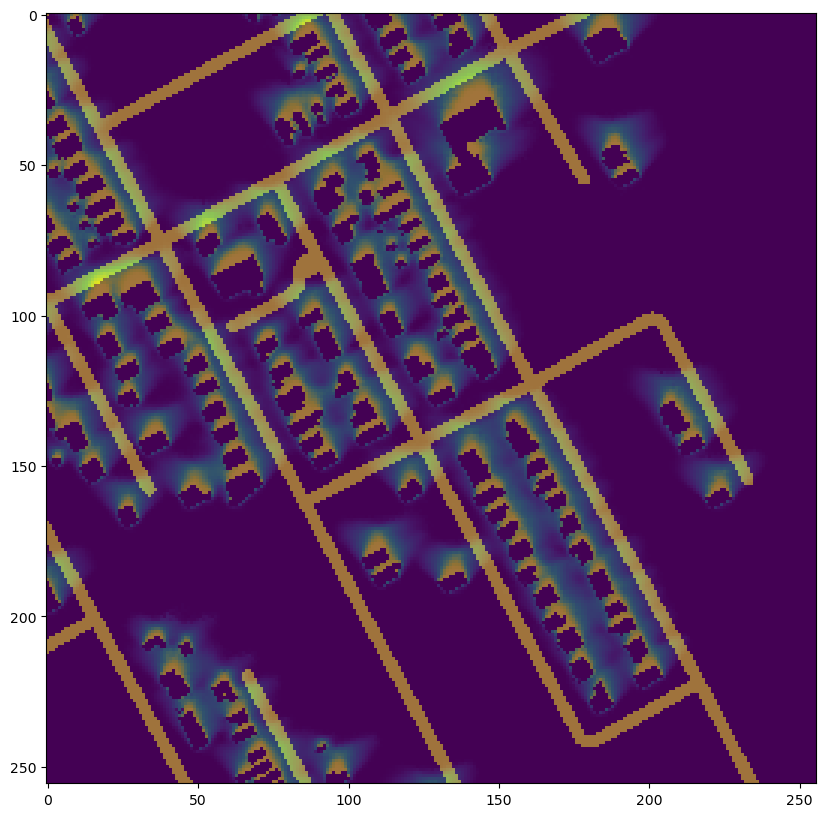

In [52]:
plt.figure(figsize=(10,10))
# load './data/shadows_new/nyc-winter/16/19265/24681.png'
plt.imshow(plt.imread('./data/shadows_new/nyc-winter/16/19262/24684.png'))
plt.imshow(plt.imread('./data/street_tile/nyc/16/19262/24684.png'), alpha=0.5)

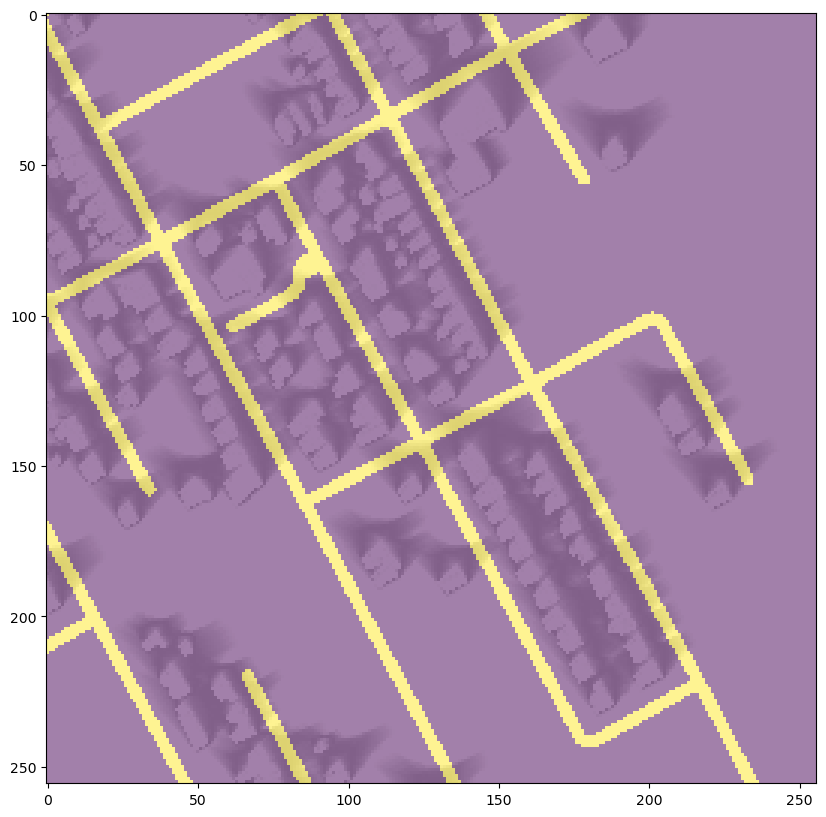

In [51]:
plt.figure(figsize=(10,10))
# load './data/shadows_new/nyc-winter/16/19265/24681.png'
plt.imshow(plt.imread('./data/shadows/nyc-winter/16/19262/24684.png'))
plt.imshow(plt.imread('./data/street_tile/nyc/16/19262/24684.png'), alpha=0.5)

In [70]:
img_gt = cv2.imread('./data/shadows/nyc-winter/16/19263/24684.png')
img_pred = cv2.imread('./data/shadows_new/nyc-winter/16/19263/24684.png')

height = cv2.imread('./data/heights_new/nyc/16/19263/24684.png')

img_gt = np.where(height > 0, 0, img_gt)

In [20]:
def get_all_tiles(height_path, shadow_path, cities, dates, zoom):
    def get_path(row, city, date):
        values = [height_path, shadow_path, city, date,
                  '%d/%d/%d.png' % (row['zoom'], row['i'], row['j'])]
        for i in range(0, 9):
            values.append(str(row[str(i)]))
        return values

    all_dataset = []
    for city in cities:
        for date in dates:
            df = pd.read_csv('data/evaluation/%s-%s-%d.csv' %
                             (city, date, zoom))
            ds = df.apply(get_path, args=(city, date), axis=1).tolist()
            all_dataset.extend(ds)

    return all_dataset

In [24]:
height_path = './data/heights_new/'
shadow_path = './data/shadows/'

BATCH_SIZE = 1
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']
dates = ['summer', 'winter', 'spring']

lat, dat = True, True

In [25]:
tf.keras.backend.clear_session()

_attn = False
gen = 'resnet9'
checkpoint_name = 'uniform_cities__street_error'

down_stack, up_stack = get_generator_arch(gen, attn = _attn)
deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type=gen, attention=_attn)
deep_shadow.restore('training_checkpoints_new/uniform_cities__street_error')

In [26]:
# Street Shadow Error for Seven Cities:

df = pd.DataFrame(columns=['city', 'date', 'rmse', 'mae', 'mse', 'ssim', 'sobel'])

t_rmses, t_maes, t_mses, t_ssims, t_sobels = 0, 0, 0, 0, 0

for city in test_cities:
    for date in dates:
        test = [city]
        test_dataset = get_all_tiles(height_path, shadow_path, test, [date], 16)
        test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

        rmses, maes, mses, ssims,  sobels = get_metrics(test_dataset, deep_shadow.generator, latitude=lat, date=dat)
        print('\nCity: %s Date: %s rmse: %.4f mae: %.4f mse: %.4f ssim: %.4f sobel: %.4f ' %
            (city, date, np.average(rmses), np.average(maes), np.average(mses), np.average(ssims), np.average(sobels)))

        # add to dataframe
        new_row = {'city': city, 'date': date, 'rmse': np.average(rmses), 'mae': np.average(maes), 'mse': np.average(mses), 'ssim': np.average(ssims), 'sobel': np.average(sobels)}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        t_rmses += np.average(rmses)
        t_maes += np.average(maes)
        t_mses += np.average(mses)
        t_ssims += np.average(ssims)
        t_sobels += np.average(sobels)

df.to_csv('./data/uniform_cities__street_error.csv')
print('\nAvg rmse: %.4f mae: %.4f mses: %.4f ssim: %.4f sobel: %.4f' 
        % (t_rmses/(3*len(test_cities)), t_maes/(3*len(test_cities)), t_mses/(3*len(test_cities)), 
            t_ssims/(3*len(test_cities)), t_sobels/(3*len(test_cities))))


City: dc Date: summer rmse: 0.0176 mae: 0.0036 mse: 0.0006 ssim: 0.0363 sobel: 0.0053 

City: dc Date: winter rmse: 0.0478 mae: 0.0109 mse: 0.0030 ssim: 0.0758 sobel: 0.0286 

City: dc Date: spring rmse: 0.0225 mae: 0.0044 mse: 0.0011 ssim: 0.0371 sobel: 0.0093 

City: nyc Date: summer rmse: 0.0189 mae: 0.0043 mse: 0.0005 ssim: 0.0330 sobel: 0.0046 

City: nyc Date: winter rmse: 0.0392 mae: 0.0089 mse: 0.0020 ssim: 0.0408 sobel: 0.0173 

City: nyc Date: spring rmse: 0.0257 mae: 0.0058 mse: 0.0009 ssim: 0.0380 sobel: 0.0085 

City: joh Date: summer rmse: 0.0132 mae: 0.0033 mse: 0.0003 ssim: 0.0764 sobel: 0.0021 

City: joh Date: winter rmse: 0.0073 mae: 0.0008 mse: 0.0002 ssim: 0.0055 sobel: 0.0021 

City: joh Date: spring rmse: 0.0057 mae: 0.0007 mse: 0.0001 ssim: 0.0070 sobel: 0.0013 

City: bue Date: summer rmse: 0.0095 mae: 0.0016 mse: 0.0002 ssim: 0.0158 sobel: 0.0017 

City: bue Date: winter rmse: 0.0225 mae: 0.0036 mse: 0.0009 ssim: 0.0294 sobel: 0.0070 

City: bue Date: spring 

In [ ]:
# Did not consider that tiles may not have streets
# City: dc rmse: 0.0118 mae: 0.0027 mse: 0.0002 ssim: 0.0163 sobel: 0.0020

In [20]:
a = np.array([0,0,0,0])
all_zeros = not np.any(a)
all_zeros = not a.any()

print(all_zeros)

True
